# **Title: 11.2 Exercise**
# **Author: Michael J. Montana**
# **Date: 28 May 2023**
# **Modified By: N/A**
# **Description: Sentiment Analysis using Deep Learning**

# <font color=6220e6>**Using the hotel reviews dataset from Week 10, create a deep learning model with the same universal sentence encoder used in Chapter 10 of the text. Create the same types of output, especially the model evaluation metrics.**

In [1]:
import pandas as pd
hotel_df = pd.read_csv('data/hotel-reviews.csv')

# <font color=6220e6>**Cleaning**

In [2]:
from myclassesv6 import Normalize_Corpus
import nltk
#using nltk stopword list with but, not, and no removed
stopword_list=nltk.corpus.stopwords.words('english')
stopword_list.remove("but")
stopword_list.remove("not")
stopword_list.remove("no")

norm=Normalize_Corpus()#instantitaing class

# cleaning hotel data
hotel_clean = hotel_df
print('Hotel Reviews:')
hotel_clean['Description']= norm.normalize(hotel_clean['Description'],stopword_list, html_stripping=True, contraction_expansion=True,
                                             accented_char_removal=True, text_lower_case=True,
                                             text_lemmatization=True, special_char_removal=True,
                                             stopword_removal=True, digits_removal=True)

Hotel Reviews:


Cleaning: 100%|██████████| 9/9 [12:54<00:00, 86.08s/it] 


# <font color=6220e6>**Saving Clean Data Set**

In [3]:
dataset=hotel_clean.copy()
dataset['sentiment'] = dataset['Is_Response'].astype('category').cat.codes
dataset = dataset.rename(columns={'Description':'review'})
dataset = dataset.drop(columns=['User_ID','Browser_Used','Device_Used','Is_Response'])
dataset.to_csv('data/hotel-reviews_clean.csv', index=False)

# <font color=6220e6>**Importing Cleaned data and Splitting to Training, Testing, and Validation Datasets**

In [4]:
from sklearn.model_selection import train_test_split  #https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
import pandas as pd
dataset = pd.read_csv('data/clean_hotel_review.csv')
#splitting dataset into training and testing; using stratify to match positive/negative ratios for the samples
rev_train, rev_test, sen_train, sen_test = train_test_split(dataset['review'], dataset['sentiment'], test_size=.15,random_state=1, stratify=dataset['sentiment'])
#splitting validation from training
rev_train, rev_val, sen_train, sen_val = train_test_split(rev_train, sen_train, test_size=.17, random_state=1, stratify=sen_train)

In [5]:
#combining and resetting the index the split data and reset the index
rev=pd.concat([rev_train,rev_val,rev_test],ignore_index=False)
sen=pd.concat([sen_train,sen_val,sen_test],ignore_index=False)
dataset2 = pd.concat([rev,sen],axis=1)

In [6]:
#splitting the data as show in the examples
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:27252]
train_sentiments = sentiments[:27252]

val_reviews = reviews[27252:33091]
val_sentiments = sentiments[27252:33091]

test_reviews = reviews[33091:]
test_sentiments = sentiments[33091:]

train_reviews.shape, val_reviews.shape, test_reviews.shape

((27252,), (5839,), (5841,))

# <font color=6220e6>**Data Ingestion Functions**

In [7]:
import tensorflow as tf
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    {'sentence': train_reviews}, train_sentiments,
    batch_size=100, num_epochs=None, shuffle=True)

In [8]:
# Prediction on the whole training set.
predict_train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    {'sentence': train_reviews}, train_sentiments, shuffle=False)

In [9]:
# Prediction on the whole validation set.
predict_val_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    {'sentence': val_reviews}, val_sentiments, shuffle=False)

In [10]:
# Prediction on the test set.
predict_test_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    {'sentence': test_reviews}, test_sentiments, shuffle=False)

# <font color=6220e6>**Deep Learning Model with Universal Sentence Encoder**

In [11]:
import tensorflow_hub as hub
#build deep learning model with universal sentecnce encoder
#TF2.0 Saved Model (v4): Encoder of greater-than-word length text trained on a variety of data
embedding_feature = hub.text_embedding_column(
    key='sentence',
    module_spec="https://tfhub.dev/google/universal-sentence-encoder/2",
    trainable=False)

In [12]:
# A classifier for Tensor Flow DNN models which is deprecated and not recommended for new code. https://www.tensorflow.org/api_docs/python/tf/compat/v1/estimator/DNNClassifier
dnn = tf.compat.v1.estimator.DNNClassifier(
    hidden_units=[512, 128],
    feature_columns=[embedding_feature],
    n_classes=2,
    activation_fn=tf.nn.relu,
    dropout=0.1,
    optimizer=tf.compat.v1.train.AdagradOptimizer(learning_rate=0.005))

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\MICHAE~1\\AppData\\Local\\Temp\\tmp4qrbpr7c', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\MICHAE~1\\AppData\\Local\\Temp\\tmp4qrbpr7c', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# <font color=6220e6>**Model Training**

In [13]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import time

TOTAL_STEPS = 100 #change to 100 per instruction
STEP_SIZE = 10 #change to 10 per instruction
for step in range(0, TOTAL_STEPS+1, STEP_SIZE):
    print()
    print('-'*100)
    print('Training for step =', step) #provides a reference
    start_time = time.time() #capturing start time
    dnn.train(input_fn=train_input_fn, steps=STEP_SIZE) #
    elapsed_time = time.time() - start_time #calculates training time
    print('Train Time (s):', elapsed_time) #print training time
    print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn)) #evaluate using training data -- https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
    print('Eval Metrics (Validation):', dnn.evaluate(input_fn=predict_val_input_fn))


----------------------------------------------------------------------------------------------------
Training for step = 0
Train Time (s): 24.56814932823181
Eval Metrics (Train): {'accuracy': 0.6831792, 'accuracy_baseline': 0.68317926, 'auc': 0.83331925, 'auc_precision_recall': 0.73225534, 'average_loss': 0.56829166, 'label/mean': 0.31682077, 'loss': 72.70932, 'precision': 0.0, 'prediction/mean': 0.30049092, 'recall': 0.0, 'global_step': 10}
Eval Metrics (Validation): {'accuracy': 0.67357427, 'accuracy_baseline': 0.6735742, 'auc': 0.8427738, 'auc_precision_recall': 0.7571548, 'average_loss': 0.5744241, 'label/mean': 0.32642576, 'loss': 72.9144, 'precision': 0.0, 'prediction/mean': 0.30001217, 'recall': 0.0, 'global_step': 10}

----------------------------------------------------------------------------------------------------
Training for step = 10
Train Time (s): 23.204465627670288
Eval Metrics (Train): {'accuracy': 0.79318947, 'accuracy_baseline': 0.68317926, 'auc': 0.8542784, 'auc_

# <font color=6220e6>**Model Eval**

In [14]:
# Evaluating deep neural network model using test and training dataset
dnn.evaluate(input_fn=predict_train_input_fn)
dnn.evaluate(input_fn=predict_test_input_fn)

{'accuracy': 0.8406095,
 'accuracy_baseline': 0.67967814,
 'auc': 0.89957637,
 'auc_precision_recall': 0.83305323,
 'average_loss': 0.37111276,
 'label/mean': 0.32032186,
 'loss': 47.123253,
 'precision': 0.8259362,
 'prediction/mean': 0.28512377,
 'recall': 0.636558,
 'global_step': 110}

In [15]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

predictions = get_predictions(estimator=dnn, input_fn=predict_test_input_fn)
predictions[:10]

[0, 1, 0, 1, 1, 0, 0, 1, 0, 1]

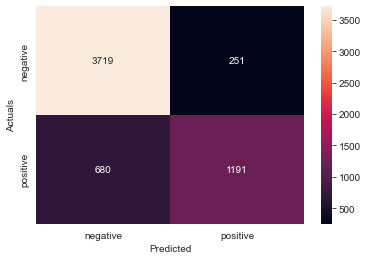

In [16]:
#producing a heatmap of the confusion matrix to show correct and incorrect prediction
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

with tf.compat.v1.Session() as session:
    cm = tf.compat.v1.confusion_matrix(test_sentiments, predictions).eval()

LABELS = ['negative', 'positive']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_true=test_sentiments, y_pred=predictions, target_names=LABELS))

              precision    recall  f1-score   support

    negative       0.85      0.94      0.89      3970
    positive       0.83      0.64      0.72      1871

    accuracy                           0.84      5841
   macro avg       0.84      0.79      0.80      5841
weighted avg       0.84      0.84      0.83      5841

